In [1]:
%reload_ext watermark

In [2]:
%watermark -a 'Yam' -d -v -h -m -p tensorflow

Yam 2017-05-24 

CPython 2.7.6
IPython 5.1.0

tensorflow 1.0.1

compiler   : GCC 4.8.4
system     : Linux
release    : 4.4.0-21-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit
host name  : 69127fc538bc


In [1]:
import time
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import jieba
%matplotlib inline

In [2]:
# 模型参数
filename = '../AssisantEvaluate/xiyouji.txt'
file_read_size = 50000 # 设为 0 时全部读取
word_embedding_dim = 30
num_units = 30 # units of RNN cell
vocab_min_freq = 5 # 计入词表的最小词频
rnn_cell_type = 'LSTM'

### 读取语料，生成训练数据

In [3]:
PADDING = '<PAD>'
START = '<START>' # 句首 token
UNKNOWN = '<UNK>'
VOCAB_SPECIAL = (PADDING, START, UNKNOWN)
END_PUNC = u'。！？'
IGNORE = u'\n “” " 《》 <> () （） *'

In [4]:
def text2sentence(text):
    sentences = []
    sentence = []
    for word in jieba.cut(text):
        if word not in IGNORE:
            sentence.append(word)
        if word in END_PUNC:
            sentences.append(sentence)
            sentence = []
    return sentences

def prepend_start_token(sentences):
    return [[START] + sen for sen in sentences]

def build_vocab(sentences):
    vocab = list(VOCAB_SPECIAL)
    words_flat = [word for sen in sentences for word in sen]
    word_cnt = Counter(words_flat)
    for word, count in word_cnt.most_common():
        if count >= vocab_min_freq:
            vocab.append(word)
    return vocab

def word2id(word):
    if word not in vocab:
        word = UNKNOWN
    return word2id_dict[word]

def sentences2ids(sentences):
    return [[word2id(word) for word in s] for s in sentences]

In [5]:
pwd

u'/notebooks/OMOOC.DeepLearning/w6_RNN'

In [6]:
with open(filename, 'r') as f:
    text = f.read(file_read_size).decode('utf-8') if file_read_size else f.read()

sentences = text2sentence(text)
vocab = build_vocab(sentences)
vocab_size = len(vocab)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.595 seconds.
Prefix dict has been built succesfully.


In [7]:
len(vocab)

241

In [8]:
word2id_dict = {word: i for i, word in enumerate(vocab)}

In [9]:
sentences = prepend_start_token(sentences)

In [10]:
len(sentences)

710

In [11]:
train_data = sentences2ids(sentences)

In [12]:
len(train_data)

710

In [13]:
np.asarray([train_data])[-1,-2]#[:,:-1]

[1, 11, 180, 49, 2, 2, 2, 2, 3, 2, 223, 4, 2, 175, 2, 5]

In [14]:
np.asarray([train_data])[:,:-1][-1,-1]

[1, 11, 180, 49, 2, 2, 2, 2, 3, 2, 223, 4, 2, 175, 2, 5]

In [15]:
def generate_batch(train_data, batch_size):
    for i in range(0, len(train_data), batch_size):
        batch = train_data[i:i+batch_size]
        max_len_of_batch = max([len(i) for i in batch])
        for j in range(len(batch)):
            batch[j].extend([0] * (max_len_of_batch - len(batch[j])))
        batch_data = np.asarray(batch)
        batch_inputs = batch_data[:,:-1]
        batch_labels = batch_data[:, 1:]
        yield batch_inputs, batch_labels

# 当 batch_size 等于总句数时，得到的即为全体样本训练数据
all_inputs, all_labels = list(generate_batch(train_data, len(train_data)))[0]
all_inputs.shape, all_labels.shape

((710, 98), (710, 98))

### 构建 RNN

In [16]:
tf.reset_default_graph()

if rnn_cell_type == 'vanilla':
    cell = tf.contrib.rnn.BasicRNNCell(num_units)
elif rnn_cell_type == 'LSTM':
    cell = tf.contrib.rnn.BasicLSTMCell(num_units)
else:
    raise ValueError('Not a valid cell type')

word_embedding = tf.Variable(tf.random_uniform([vocab_size, word_embedding_dim]))

inputs = tf.placeholder(tf.int32, shape=[None, None], name='inputs')
labels = tf.placeholder(tf.int32, shape=[None, None], name='labels')
labels_flat = tf.reshape(labels, (-1,))

input_embeds = tf.nn.embedding_lookup(word_embedding, inputs)

In [17]:
labels_flat

<tf.Tensor 'Reshape:0' shape=(?,) dtype=int32>

In [18]:
input_embeds

<tf.Tensor 'embedding_lookup:0' shape=(?, ?, 30) dtype=float32>

In [19]:
squence_length = tf.reduce_sum(tf.sign(inputs), axis=1)
squence_length

<tf.Tensor 'Sum:0' shape=(?,) dtype=int32>

In [20]:
max_sequence_length = tf.reduce_max(squence_length)
max_sequence_length

<tf.Tensor 'Max:0' shape=() dtype=int32>

In [21]:
output, states = tf.nn.dynamic_rnn(cell, input_embeds, dtype=tf.float32, sequence_length=squence_length)
output, states

(<tf.Tensor 'rnn/transpose:0' shape=(?, ?, 30) dtype=float32>,
 LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_2:0' shape=(?, 30) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 30) dtype=float32>))

In [22]:
output_flat = tf.reshape(output, (-1, num_units))
output_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 30) dtype=float32>

In [23]:
softmax_w = tf.Variable(tf.random_uniform([num_units, vocab_size]))
softmax_b = tf.Variable(tf.random_uniform([vocab_size]))
softmax_w, softmax_b

(<tensorflow.python.ops.variables.Variable at 0x7ff930c19910>,
 <tensorflow.python.ops.variables.Variable at 0x7ff9261de290>)

In [24]:
logits_flat = tf.matmul(output_flat, softmax_w) + softmax_b
logits_flat

<tf.Tensor 'add:0' shape=(?, 241) dtype=float32>

In [29]:
probs_flat = tf.nn.softmax(logits_flat)
probs_flat

<tf.Tensor 'Softmax:0' shape=(?, 241) dtype=float32>

In [30]:
probs = tf.reshape(probs_flat, (-1, max_sequence_length, vocab_size))
probs

<tf.Tensor 'Reshape_2:0' shape=(?, ?, 241) dtype=float32>

In [31]:
losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_flat, labels=labels_flat)
losses

<tf.Tensor 'SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits:0' shape=(?,) dtype=float32>

### mask 修正 loss

In [32]:
mask = tf.cast(tf.sign(labels_flat), tf.float32)
loss = tf.reduce_sum(losses * mask)
loss

<tf.Tensor 'Sum_1:0' shape=() dtype=float32>

### 训练

In [34]:
# 参数
learning_rate = 0.1
batch_size = 10
epochs = 50
print_loss_every = 5

epoch 0: cost = 95009.2
epoch 5: cost = 87259.2
epoch 10: cost = 96762.5
epoch 15: cost = 59590.5
epoch 20: cost = 48462.4
epoch 25: cost = 46892.6
epoch 30: cost = 54520.7
epoch 35: cost = 51900.5
epoch 40: cost = 50622.7
epoch 45: cost = 46782.3
train time: 167.840034008


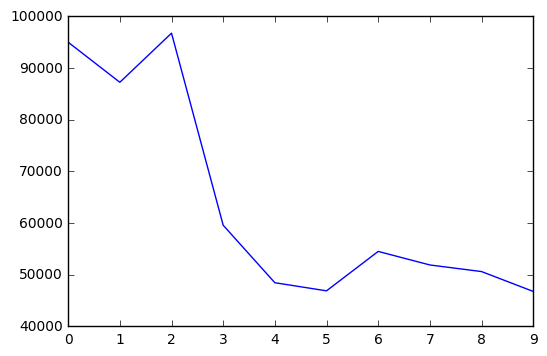

In [35]:
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
all_feed = {inputs: all_inputs, labels: all_labels}
loss_history = []

sess = tf.Session()
sess.run(tf.global_variables_initializer())
start_time = time.time()

try:
    for i in range(epochs):
        for inp, lab in generate_batch(train_data, batch_size):
            batch_feed = {inputs: inp, labels: lab}
            sess.run(train_step, feed_dict=batch_feed)
        if i % print_loss_every == 0:
            loss_val = sess.run(loss, feed_dict=all_feed)
            loss_history.append(loss_val)
            print('epoch %s: cost = %s' % (i, loss_val))
except KeyboardInterrupt:
    print('KeyboardInterrupt')
end_time = time.time()
print("train time: %s" % (end_time - start_time))
plt.plot(loss_history)

In [36]:
# 从三阶张量中提取出生成模型时下一个词的概率分布
probs_next_word = probs[0,-1,:]
probs_next_word.shape

TensorShape([Dimension(241)])

In [49]:
word_ids = [word2id(START)]
context = u'你出来等着我'
print START
for w in jieba.cut(context):    
    if w not in vocab:
        w = UNKNOWN
    print w
    word_ids.append(word2id_dict[w])
for w in word_ids:
    print w

<START>
你
出来
等
着
我
1
10
67
38
42
8


In [50]:
test = np.asarray([38,8]).reshape(1, -1)

In [51]:
probs_val = sess.run(probs_next_word, feed_dict={inputs: test})

In [65]:
probs_val[58]

0.0043021422

In [61]:
word2id_dict[u'徒弟']

55

### 生成句子

步骤：  

- 由句首 token，生成第一个词
- 由已有的词生成下一个词
- 直到生成 END_PUNC 为止
- 如果生成了 UNK：重新生成

In [78]:
# 从三阶张量中提取出生成模型时下一个词的概率分布
probs_next_word = probs[0,-1,:]
probs_next_word.shape

TensorShape([Dimension(241)])

In [84]:
def generate_sentence(topk):
    word_ids = [word2id(START)]
    
    for i in range(100): # 句子长度上限
        context = np.asarray(word_ids).reshape(1, -1)
        probs_val = sess.run(probs_next_word, feed_dict={inputs: context})
        
        topk_indices = probs_val.argsort()[-topk:][::-1]
        topk_probs = [probs_val[i] for i in topk_indices]
        
        for j in range(100): # 尝试次数上限
            # 从概率最大的 topk 个词中随机抽取
            new_id = np.random.choice(topk_indices, p=topk_probs/sum(topk_probs))
            new_word = vocab[new_id]
            if new_word not in VOCAB_SPECIAL:
                break
        word_ids.append(new_id)
        if new_word in END_PUNC:
            break
    sentence = [vocab[i] for i in word_ids]
    return ''.join(sentence[1:])

for i in range(5):
    print(generate_sentence(topk=20))

我的是在的他了这叫那高就了又在。
我们这太保行者又，这个你我是这一个了是，，道又又他道见：既未道心这在见那见那
却说从这大圣不去是
来了这是我来
人家那得这般他在道
我了的是道吃！
我我来模样一块这
只在我，，是是你，那
—一个了，又在我！
还你在在是。
还，！
